### 1. 환경설정 및 데이터 import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
import pickle

TOTAL_URLS = 3000  # total number in the dataset

'''
In the unmonitored dataset, there is no 'y' array since it has a single label.
You can assign a number that is not used in the monitored set, such as -1 or 95,
as the label for unmonitored websites.
'''

path = '/content/unmon_standard10_3000.pkl'
with open(path, "rb") as f:
    x = pickle.load(f)

size = len(x)
print(f'Total samples: {size}')

timestamps = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
instances = [] # Array to store instances (direction*size) - size information

# unmon_standard10.pkl > array code
for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    timestamps.append(time_seq)
    instances.append(size_seq)

print('done')

Total samples: 3000
done


### 2. 데이터 구조

In [ ]:
unmon_data = x

# 구조 확인

print("data type:", type(unmon_data))
print("Total samples:", len(unmon_data))

# 첫 번째 trace 예시
# print("\n첫 번째 trace 타입:", type(unmon_data[0]))
# print("길이:", len(unmon_data[0]))
# print(len(unmon_data[1]))

i = 0
print(len(unmon_data[i]))
print(f'unmon_data[{i}]:', unmon_data[i])

data type: <class 'list'>
Total samples: 3000
130
unmon_data[0]: [0.0, -0.13, 0.13, -0.36, 0.83, -1.1, 1.1, -1.35, -1.35, 2.1, 2.1, 2.22, -2.35, 2.35, 2.35, -2.47, 2.47, -2.58, 2.58, 2.58, -2.69, -2.69, -2.69, -2.69, -2.69, -2.69, 2.7, 2.7, -2.81, -2.81, -2.81, 2.81, -2.92, -2.92, -2.92, -2.92, -2.92, -2.92, 2.92, 2.92, 2.92, 2.92, -3.02, 3.02, -3.13, -3.13, 3.13, 3.13, 3.13, -3.24, -3.35, -3.35, 3.35, -3.46, -3.46, -3.61, -3.61, 3.78, -4.1, -4.1, -4.1, -4.1, -4.1, -4.1, 4.18, 4.18, 4.18, -4.52, -4.52, -4.52, -4.66, -4.66, -4.66, -4.66, -4.66, -4.66, -4.66, -4.75, -4.75, -4.75, -4.75, -4.75, -4.75, -4.75, -4.75, -4.75, -4.75, -4.75, -4.75, -4.75, -4.75, -4.77, -4.77, -4.84, -4.84, -4.84, -4.84, -4.84, -4.84, 4.84, -4.85, -4.85, -4.85, -4.85, -4.85, -4.85, -4.85, -4.88, -4.88, -4.88, -4.88, -4.88, -4.88, -4.88, -4.88, 4.96, -4.99, -4.99, -4.99, -5.45, -5.45, -5.45, -5.45, -5.45, -5.45, -5.45, -5.56, -5.56, -5.56, -5.56]



Trace 길이 (최소~최대): 51 ~ 9991
평균 trace 길이: 4796.1
중앙값 trace 길이: 4206.5


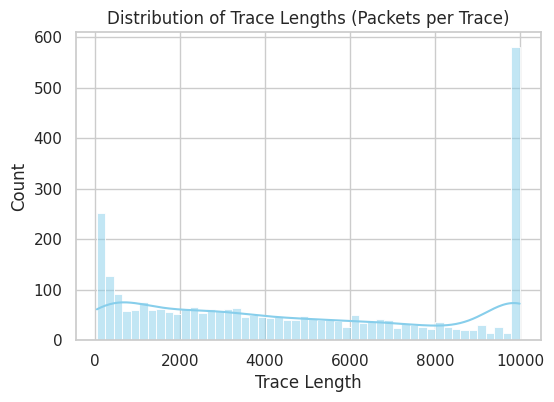

In [ ]:
# trace 길이 통계

trace_lengths = [len(trace) for trace in unmon_data]

print(f"\nTrace 길이 (최소~최대): {np.min(trace_lengths)} ~ {np.max(trace_lengths)}")
print(f"평균 trace 길이: {np.mean(trace_lengths):.1f}")
print(f"중앙값 trace 길이: {np.median(trace_lengths):.1f}")

plt.figure(figsize=(6,4))
sns.histplot(trace_lengths, bins=50, kde=True, color="skyblue")
plt.title("Distribution of Trace Lengths (Packets per Trace)")
plt.xlabel("Trace Length")
plt.ylabel("Count")
plt.show()



평균 incoming 비율: 0.901
평균 outgoing 비율: 0.097


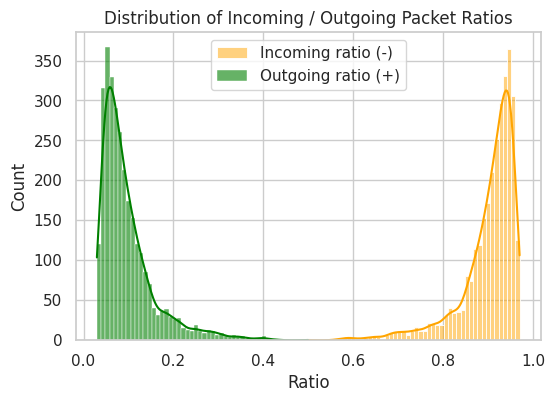

In [ ]:
# packet 방향 통계
ratio_in_list, ratio_out_list = [], []

for trace in unmon_data:
    trace = np.array(trace)
    num_in = np.sum(trace < 0)
    num_out = np.sum(trace > 0)
    total = len(trace)
    if total == 0: continue
    ratio_in_list.append(num_in / total)
    ratio_out_list.append(num_out / total)

print(f"\n평균 incoming 비율: {np.mean(ratio_in_list):.3f}")
print(f"평균 outgoing 비율: {np.mean(ratio_out_list):.3f}")

plt.figure(figsize=(6,4))
sns.histplot(ratio_in_list, bins=50, kde=True, color="orange", label="Incoming ratio (-)")
sns.histplot(ratio_out_list, bins=50, kde=True, color="green", label="Outgoing ratio (+)", alpha=0.6)
plt.title("Distribution of Incoming / Outgoing Packet Ratios")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.legend()
plt.show()


In [ ]:
# trace-level summary df

summary = []
for idx, trace in enumerate(unmon_data):
    trace = np.array(trace)
    if len(trace) == 0: continue

    num_in = np.sum(trace < 0)
    num_out = np.sum(trace > 0)
    ratio_in = num_in / len(trace)
    ratio_out = num_out / len(trace)

    # 절댓값 기준으로 트래픽 크기(시간)가 포함되어 있으면 통계 계산
    trace_abs = np.abs(trace)
    summary.append({
        "trace_id": idx,
        "trace_len": len(trace),
        "num_in": num_in,
        "num_out": num_out,
        "ratio_in": ratio_in,
        "ratio_out": ratio_out,
        "mean_abs": np.mean(trace_abs),
        "std_abs": np.std(trace_abs),
        "max_abs": np.max(trace_abs)
    })

df_unmon_summary = pd.DataFrame(summary)
display(df_unmon_summary.head())
print("\n요약 통계:")
print(df_unmon_summary.describe().T)


,trace_id,trace_len,num_in,num_out,ratio_in,ratio_out,mean_abs,std_abs,max_abs
0,0,130,100,29,0.769231,0.223077,3.799462,1.304582,5.56
1,1,9927,9188,738,0.925557,0.074343,9.884457,1.612960,11.88
2,2,359,284,74,0.791086,0.206128,9.328440,3.078579,17.81
3,3,9948,9406,541,0.945517,0.054383,7.584566,1.035998,9.17
4,4,2508,2214,293,0.882775,0.116826,10.352085,5.564661,53.59



요약 통계:
            count         mean          std        min          25%  \
trace_id   3000.0  1499.500000   866.169729   0.000000   749.750000   
trace_len  3000.0  4796.075000  3538.333903  51.000000  1508.500000   
num_in     3000.0  4442.868333  3335.276492  30.000000  1363.750000   
num_out    3000.0   352.206667   288.120793   9.000000   131.750000   
ratio_in   3000.0     0.901345     0.063203   0.500611     0.883061   
ratio_out  3000.0     0.097356     0.060933   0.029768     0.056329   
mean_abs   3000.0     9.668408     5.370177   1.130741     6.312407   
std_abs    3000.0     2.919677     2.494189   0.311134     1.327548   
max_abs    3000.0    23.520040    14.566421   2.180000    11.875000   

                   50%          75%          max  
trace_id   1499.500000  2249.250000  2999.000000  
trace_len  4206.500000  8236.500000  9991.000000  
num_in     3834.000000  7610.250000  9670.000000  
num_out     314.500000   488.000000  3270.000000  
ratio_in      0.920157    

from matplotlib import pyplot as plt
_df_0['trace_id'].plot(kind='hist', bins=20, title='trace_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['trace_len'].plot(kind='hist', bins=20, title='trace_len')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['num_in'].plot(kind='hist', bins=20, title='num_in')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['num_out'].plot(kind='hist', bins=20, title='num_out')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='trace_id', y='trace_len', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='trace_len', y='num_in', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='num_in', y='num_out', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='num_out', y='ratio_in', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['trace_id']
  ys = series['trace_len']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('trace_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('trace_id')
_ = plt.ylabel('trace_len')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['trace_id']
  ys = series['num_in']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('trace_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('trace_id')
_ = plt.ylabel('num_in')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['trace_id']
  ys = series['num_out']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('trace_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('trace_id')
_ = plt.ylabel('num_out')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['trace_id']
  ys = series['ratio_in']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('trace_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('trace_id')
_ = plt.ylabel('ratio_in')

from matplotlib import pyplot as plt
_df_12['trace_id'].plot(kind='line', figsize=(8, 4), title='trace_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['trace_len'].plot(kind='line', figsize=(8, 4), title='trace_len')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['num_in'].plot(kind='line', figsize=(8, 4), title='num_in')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['num_out'].plot(kind='line', figsize=(8, 4), title='num_out')
plt.gca().spines[['top', 'right']].set_visible(False)

### 3. Feature 추출 (Continuous & Categorical)

In [ ]:

# timestamps[i]: i번째 세션의 패킷 도착 시각 리스트
# instances[i]: i번째 세션의 패킷 방향/크기

# =====================================
# 각 trace에서 Continuous Feature 추출
# =====================================
def compute_continuous_features(timestamps, instances):
    rows = []

    for sess_idx, (t_seq, s_seq) in enumerate(tqdm(zip(timestamps, instances), total=len(timestamps))):
        t_seq = np.array(t_seq) # 패킷 발생 시각
        s_seq = np.array(s_seq)

        # Packet 사이즈
        pkt_min, pkt_max, pkt_mean, pkt_std = s_seq.min(), s_seq.max(), s_seq.mean(), s_seq.std()
        num_in = np.sum(s_seq < 0)  # 수신 패킷 개수
        num_out = np.sum(s_seq > 0) # 송신 패킷 개수

        # Timestamps
        t_min, t_max = t_seq.min(), t_seq.max() # 세션 시작~끝
        t_mean, t_med = t_seq.mean(), np.median(t_seq)  # 평균, 중앙값
        t_std = t_seq.std() # 분산
        q25, q75 = np.percentile(t_seq, [25, 75])

        # 누적 트래픽량 (Cumulative Sizes) -> throughput 비교
        cumsum = np.cumsum(s_seq)
        cum_min, cum_max, cum_mean, cum_std = cumsum.min(), cumsum.max(), cumsum.mean(), cumsum.std()

        # Bursts -> 요청-응답 주기 패턴 탐지, 사이트 복잡도 추정
        bursts = []
        cur_dir = np.sign(s_seq[0])
        cur_sum = 0
        for val in s_seq:
            if np.sign(val) == cur_dir:
                cur_sum += val
            else:
                bursts.append(cur_sum)
                cur_sum = val
                cur_dir = np.sign(val)
        bursts.append(cur_sum)
        bursts = np.array(bursts)
        burst_min, burst_max, burst_mean, burst_std, burst_cnt = bursts.min(), bursts.max(), bursts.mean(), bursts.std(), len(bursts)

        # Inter-packet times -> 서버 응답속도/안정성 파악 및 burst 패턴 분석
        inter_times = np.diff(t_seq)
        if len(inter_times) > 0:
            ipt_min, ipt_max = inter_times.min(), inter_times.max()
            ipt_mean, ipt_med, ipt_std = inter_times.mean(), np.median(inter_times), inter_times.std()
            ipt_q25, ipt_q75 = np.percentile(inter_times, [25, 75])
        else:
            ipt_min = ipt_max = ipt_mean = ipt_med = ipt_std = ipt_q25 = ipt_q75 = 0

        rows.append({
            "trace_id": sess_idx,
            "num_in": num_in,
            "num_out": num_out,
            "pkt_mean": pkt_mean,
            "pkt_std": pkt_std,
            "t_min": t_min, "t_max": t_max, "t_mean": t_mean, "t_med": t_med, "t_std": t_std,
            "t_q25": q25, "t_q75": q75,
            "cum_min": cum_min, "cum_max": cum_max, "cum_mean": cum_mean, "cum_std": cum_std,
            "burst_min": burst_min, "burst_max": burst_max, "burst_mean": burst_mean, "burst_std": burst_std,
            "burst_cnt": burst_cnt,
            "ipt_min": ipt_min, "ipt_max": ipt_max, "ipt_mean": ipt_mean, "ipt_med": ipt_med,
            "ipt_std": ipt_std, "ipt_q25": ipt_q25, "ipt_q75": ipt_q75
        })

    return pd.DataFrame(rows)

# =====================================
# 각 trace에서 Categorical Feature 추출
# =====================================
def compute_categorical_features(timestamps, instances):
    rows = []

    for sess_idx, (t_seq, s_seq) in enumerate(tqdm(zip(timestamps, instances), total=len(timestamps))):
        t_seq = np.array(t_seq)
        s_seq = np.array(s_seq)

        # Packet size
        total_packets = len(s_seq)
        num_incoming = np.sum(s_seq < 0)
        num_outgoing = np.sum(s_seq > 0)
        incoming_ratio = num_incoming / total_packets
        outgoing_ratio = num_outgoing / total_packets

        # Outgoing packet timing
        out_times = t_seq[s_seq > 0]
        outgoing_avg = out_times.mean() if len(out_times) else 0
        outgoing_std = out_times.std() if len(out_times) else 0

        # Cumulative & Burst sums
        sum_cumulative = np.cumsum(s_seq)[-1]
        bursts = []
        cur_dir = np.sign(s_seq[0])
        cur_sum = 0
        for val in s_seq:
            if np.sign(val) == cur_dir:
                cur_sum += val
            else:
                bursts.append(cur_sum)
                cur_sum = val
                cur_dir = np.sign(val)
        bursts.append(cur_sum)
        sum_bursts = np.sum(bursts)

        # Throughput
        duration = t_seq[-1] - t_seq[0] if len(t_seq) > 1 else 0
        packets_per_second = total_packets / duration if duration > 0 else 0

        # First 30 packets
        first30 = s_seq[:30]
        incoming_first30 = np.sum(first30 < 0)
        outgoing_first30 = np.sum(first30 > 0)

        rows.append({
            "trace_id": sess_idx,
            "total_packets": total_packets,
            "num_in": num_incoming,
            "num_out": num_outgoing,
            "incoming_ratio": incoming_ratio,
            "outgoing_ratio": outgoing_ratio,
            "outgoing_avg": outgoing_avg,
            "outgoing_std": outgoing_std,
            "sum_cumulative": sum_cumulative,
            "sum_bursts": sum_bursts,
            "packets_per_second": packets_per_second,
            "incoming_first30": incoming_first30,
            "outgoing_first30": outgoing_first30
        })

    return pd.DataFrame(rows)

# =====================================
# Feature 계산 및 저장
# =====================================
df_cont = compute_continuous_features(timestamps, instances)
df_cat = compute_categorical_features(timestamps, instances)

#df_cont.to_csv("unmon_continuous_features.csv", index=False)
#df_cat.to_csv("unmon_categorical_features.csv", index=False)

#print("CSV saved: unmon_continuous_features.csv, unmon_categorical_features.csv")


100%|██████████| 3000/3000 [00:23<00:00, 130.25it/s]


In [ ]:
import pandas as pd
import numpy as np

# ---------------------------------------
# 1️⃣ 두 feature DataFrame 병합
# ---------------------------------------
df_all = pd.merge(df_cont, df_cat, on="trace_id")

# 'session_id'는 식별자이므로 제거 후 correlation 계산
df_corr = df_all.drop(columns=['trace_id'])

# ---------------------------------------
# 2️⃣ 상관계수 행렬 계산
# ---------------------------------------
corr_matrix = df_corr.corr().abs()  # 절댓값으로 상관강도만 본다

# ---------------------------------------
# 3️⃣ 상위 10쌍의 상관관계 추출
# ---------------------------------------
# 자기 자신(feature vs feature)은 제외하기 위해 마스크 적용
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_pairs = corr_matrix.where(~mask)

# (feature1, feature2, corr_value) 형태로 정렬
corr_unstacked = corr_pairs.unstack().dropna().sort_values(ascending=False)

# 상위 10개 출력
top10_corr = corr_unstacked.head(10)
print("Top 10 correlated feature pairs:\n")
print(top10_corr)


Top 10 correlated feature pairs:

pkt_mean          incoming_ratio      1.000000
num_in_x          num_in_y            1.000000
num_out_x         num_out_y           1.000000
sum_cumulative    sum_bursts          1.000000
incoming_ratio    outgoing_ratio      1.000000
pkt_mean          outgoing_ratio      1.000000
incoming_first30  outgoing_first30    1.000000
cum_min           cum_std             0.999656
                  sum_cumulative      0.999627
                  sum_bursts          0.999627
dtype: float64


### 3-1. 시각화 및 분석 - Continuous

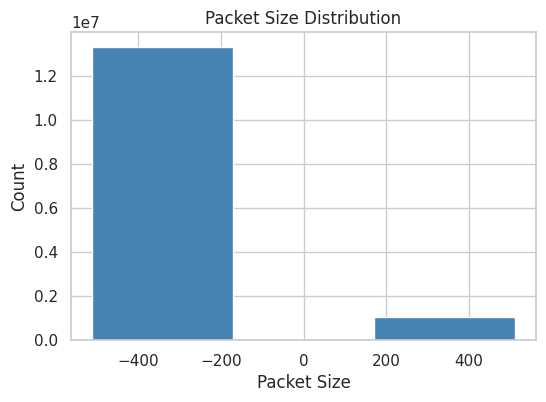

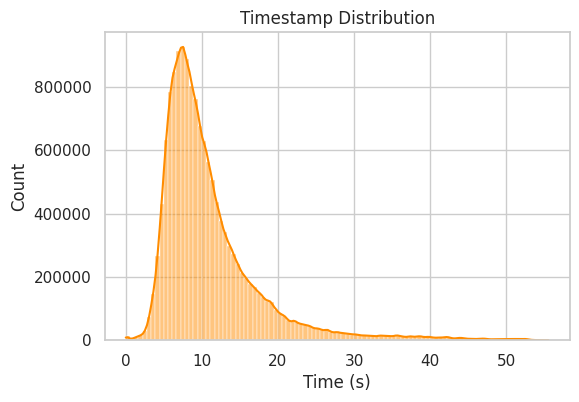

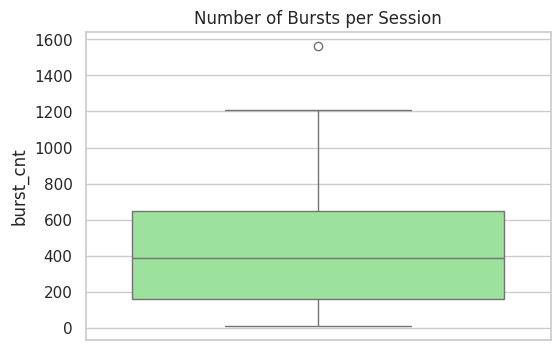

In [ ]:
sns.set(style="whitegrid")

# 패킷 사이즈 분포
all_sizes = np.concatenate(instances)
plt.figure(figsize=(6,4))
plt.hist(all_sizes, bins=3, color="steelblue")
plt.title("Packet Size Distribution")
plt.xlabel("Packet Size")
plt.ylabel("Count")
plt.show()

# timestamp 분포
all_times = np.concatenate(timestamps)
plt.figure(figsize=(6,4))
sns.histplot(all_times, bins=100, kde=True, color="darkorange")
plt.title("Timestamp Distribution")
plt.xlabel("Time (s)")
plt.show()

# 세션 당 burst 수
plt.figure(figsize=(6,4))
sns.boxplot(df_cont["burst_cnt"], color="lightgreen")
plt.title("Number of Bursts per Session")
plt.show()

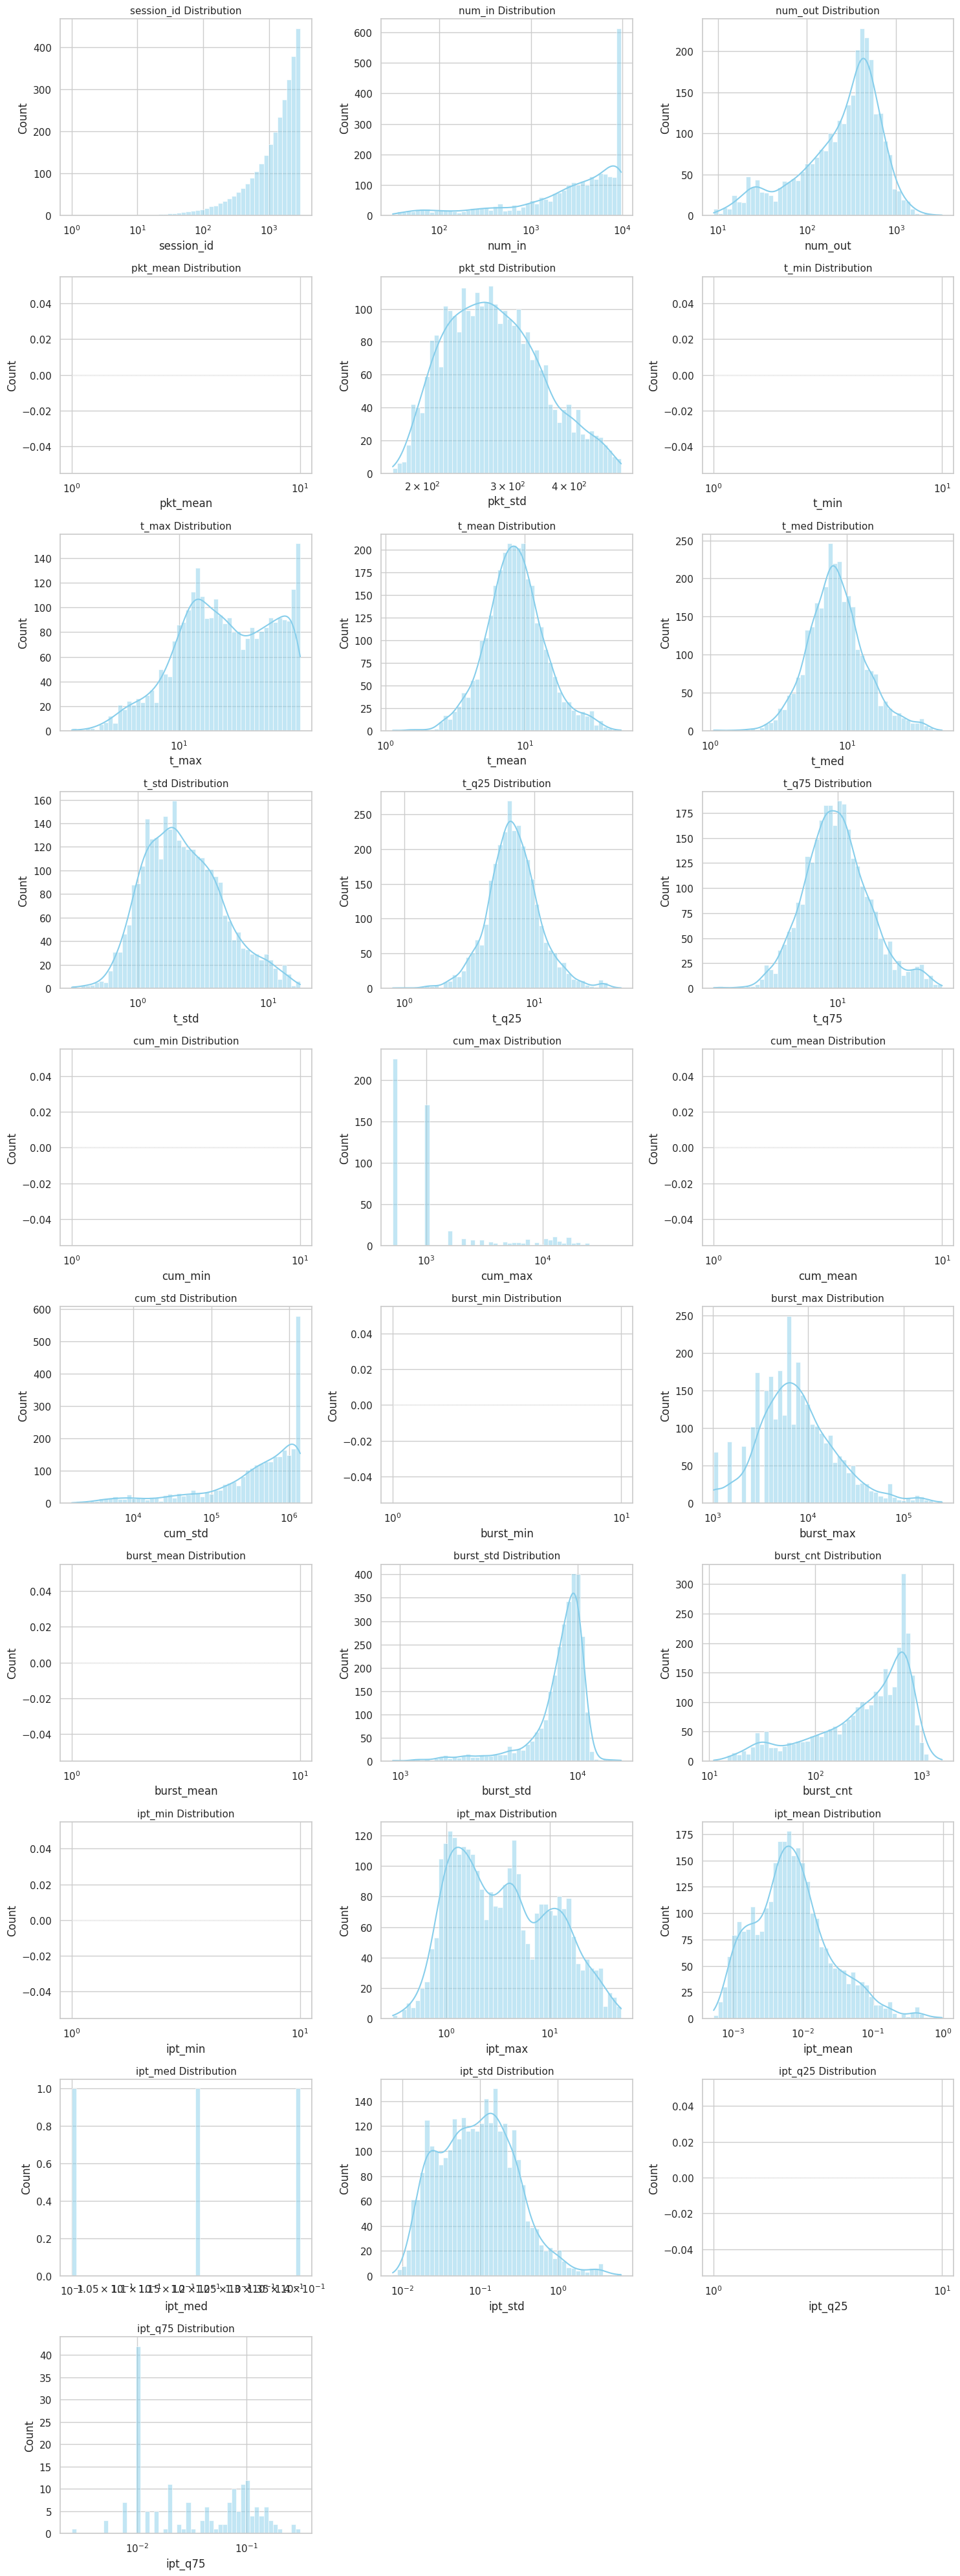

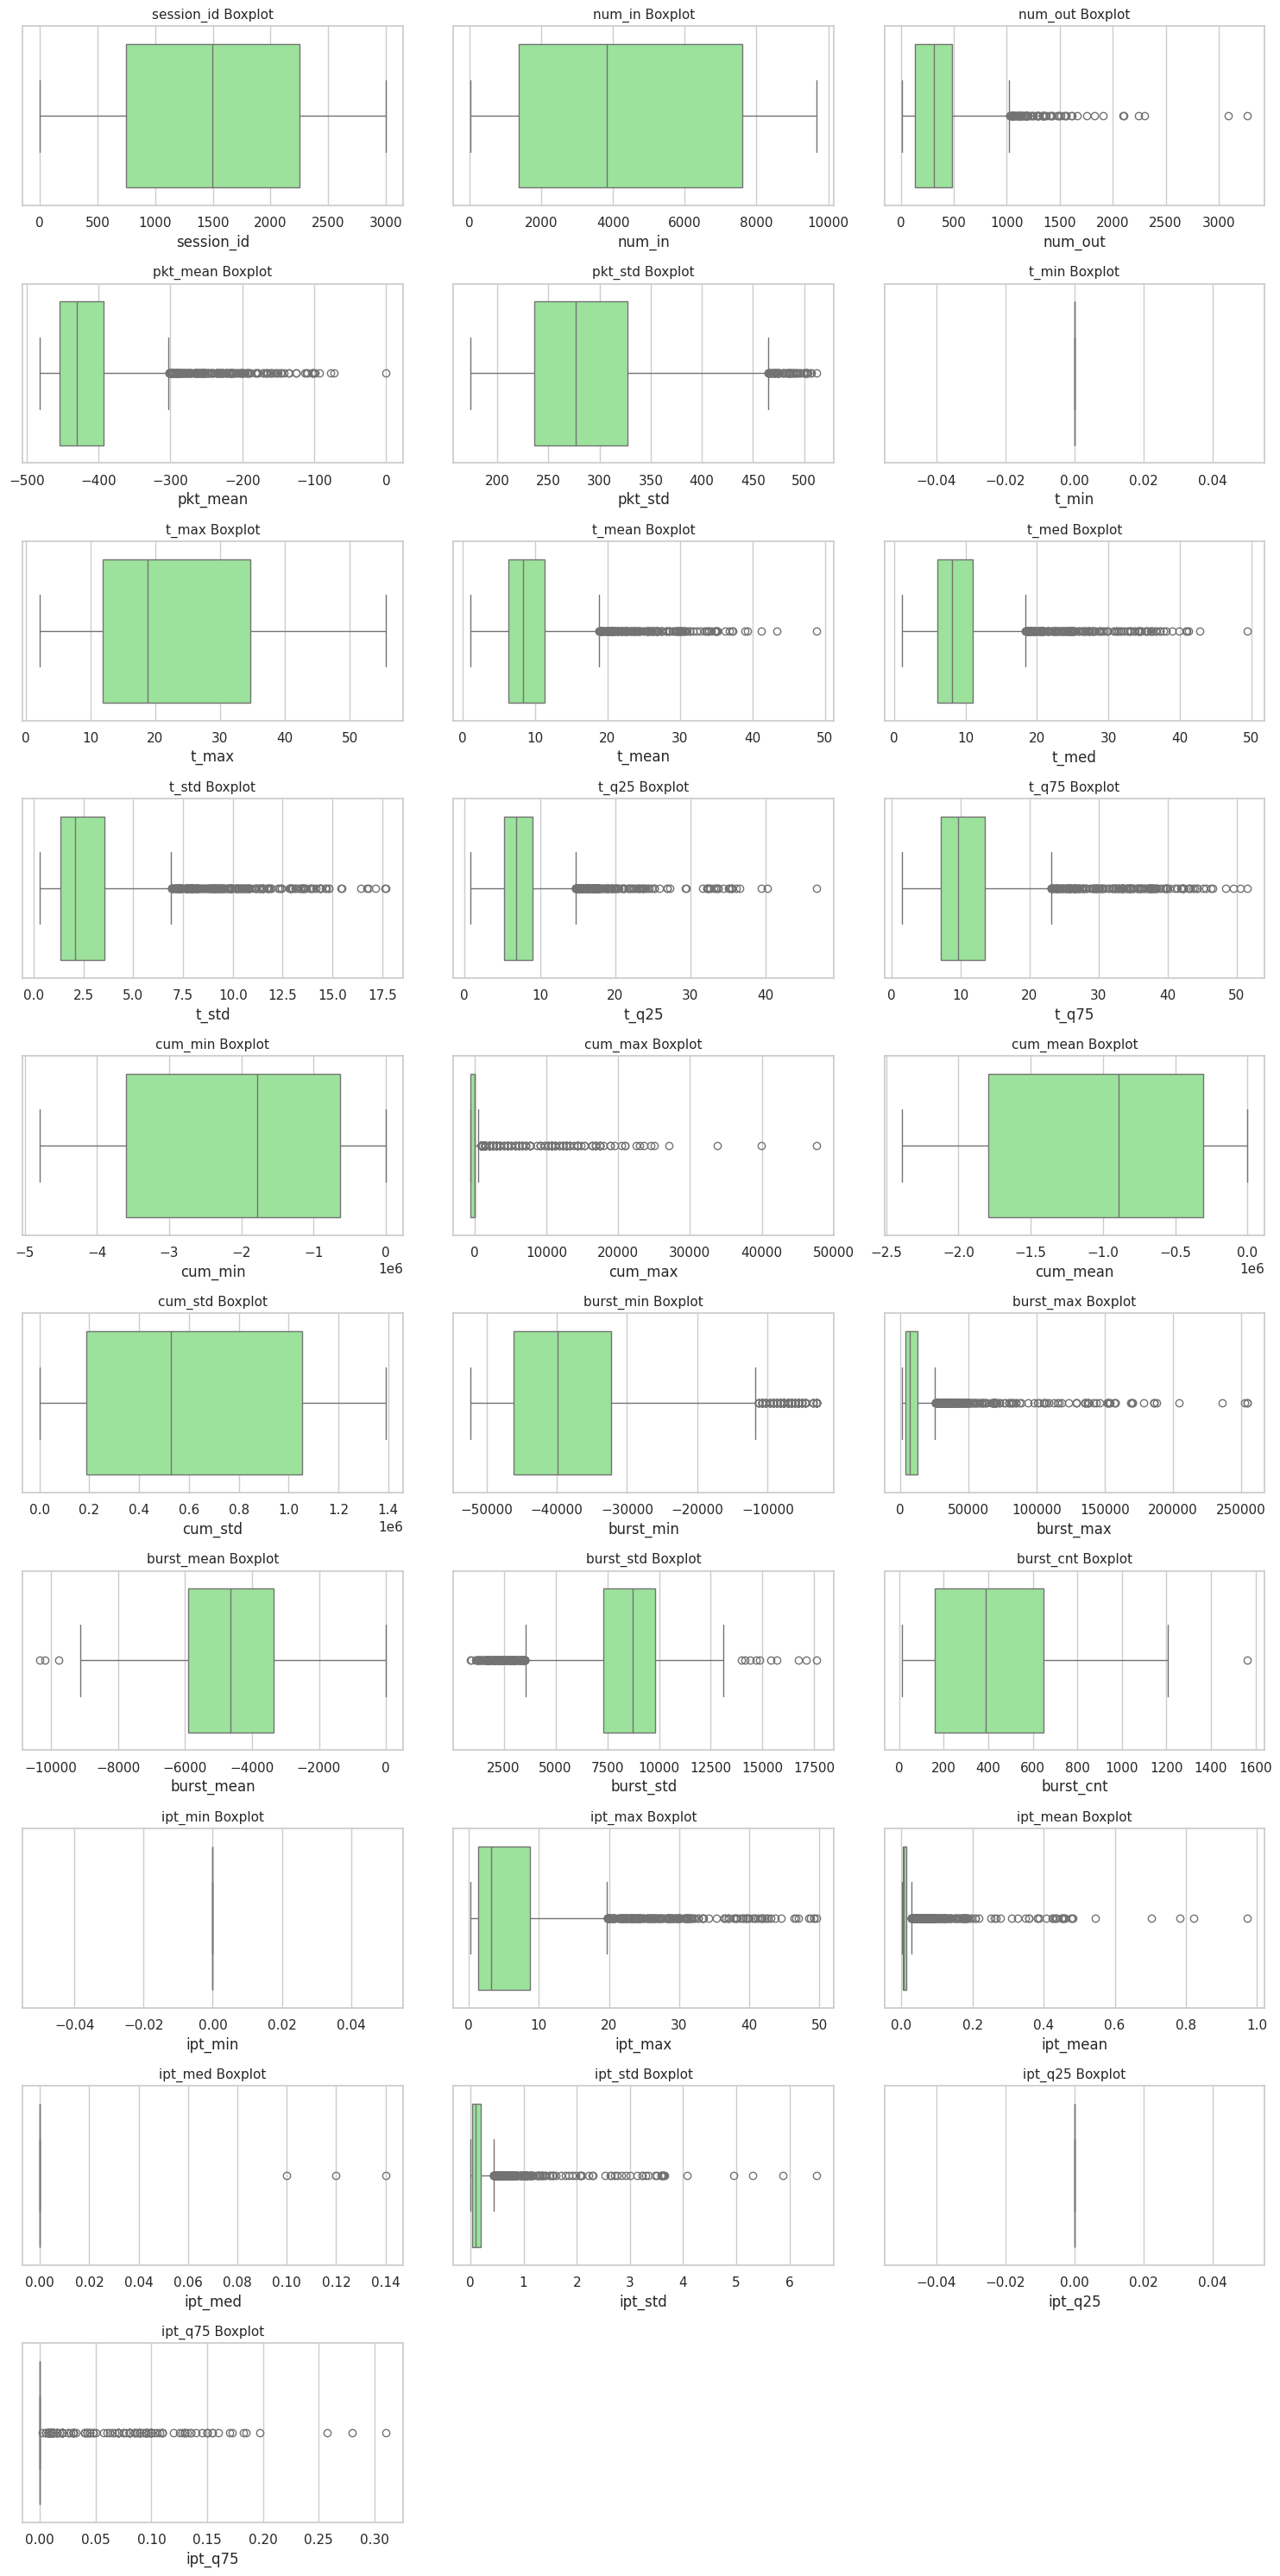

In [ ]:
# 분포 ==========================================

cont_numeric_cols = df_cont.select_dtypes(include=np.number).columns

n_cols = 3  # 한 행 3개
n_rows = int(np.ceil(len(cont_numeric_cols) / n_cols))

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(cont_numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_cont[col], kde=True, bins=50, color="skyblue", edgecolor=None, log_scale=True)
    plt.title(f"{col} Distribution", fontsize=11)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Box plot ==========================================

plt.figure(figsize=(5 * n_cols, 3 * n_rows))

for i, col in enumerate(cont_numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df_cont[col], color="lightgreen")
    plt.title(f"{col} Boxplot", fontsize=11)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

### 3-2. 시각화 및 분석 - Categorical

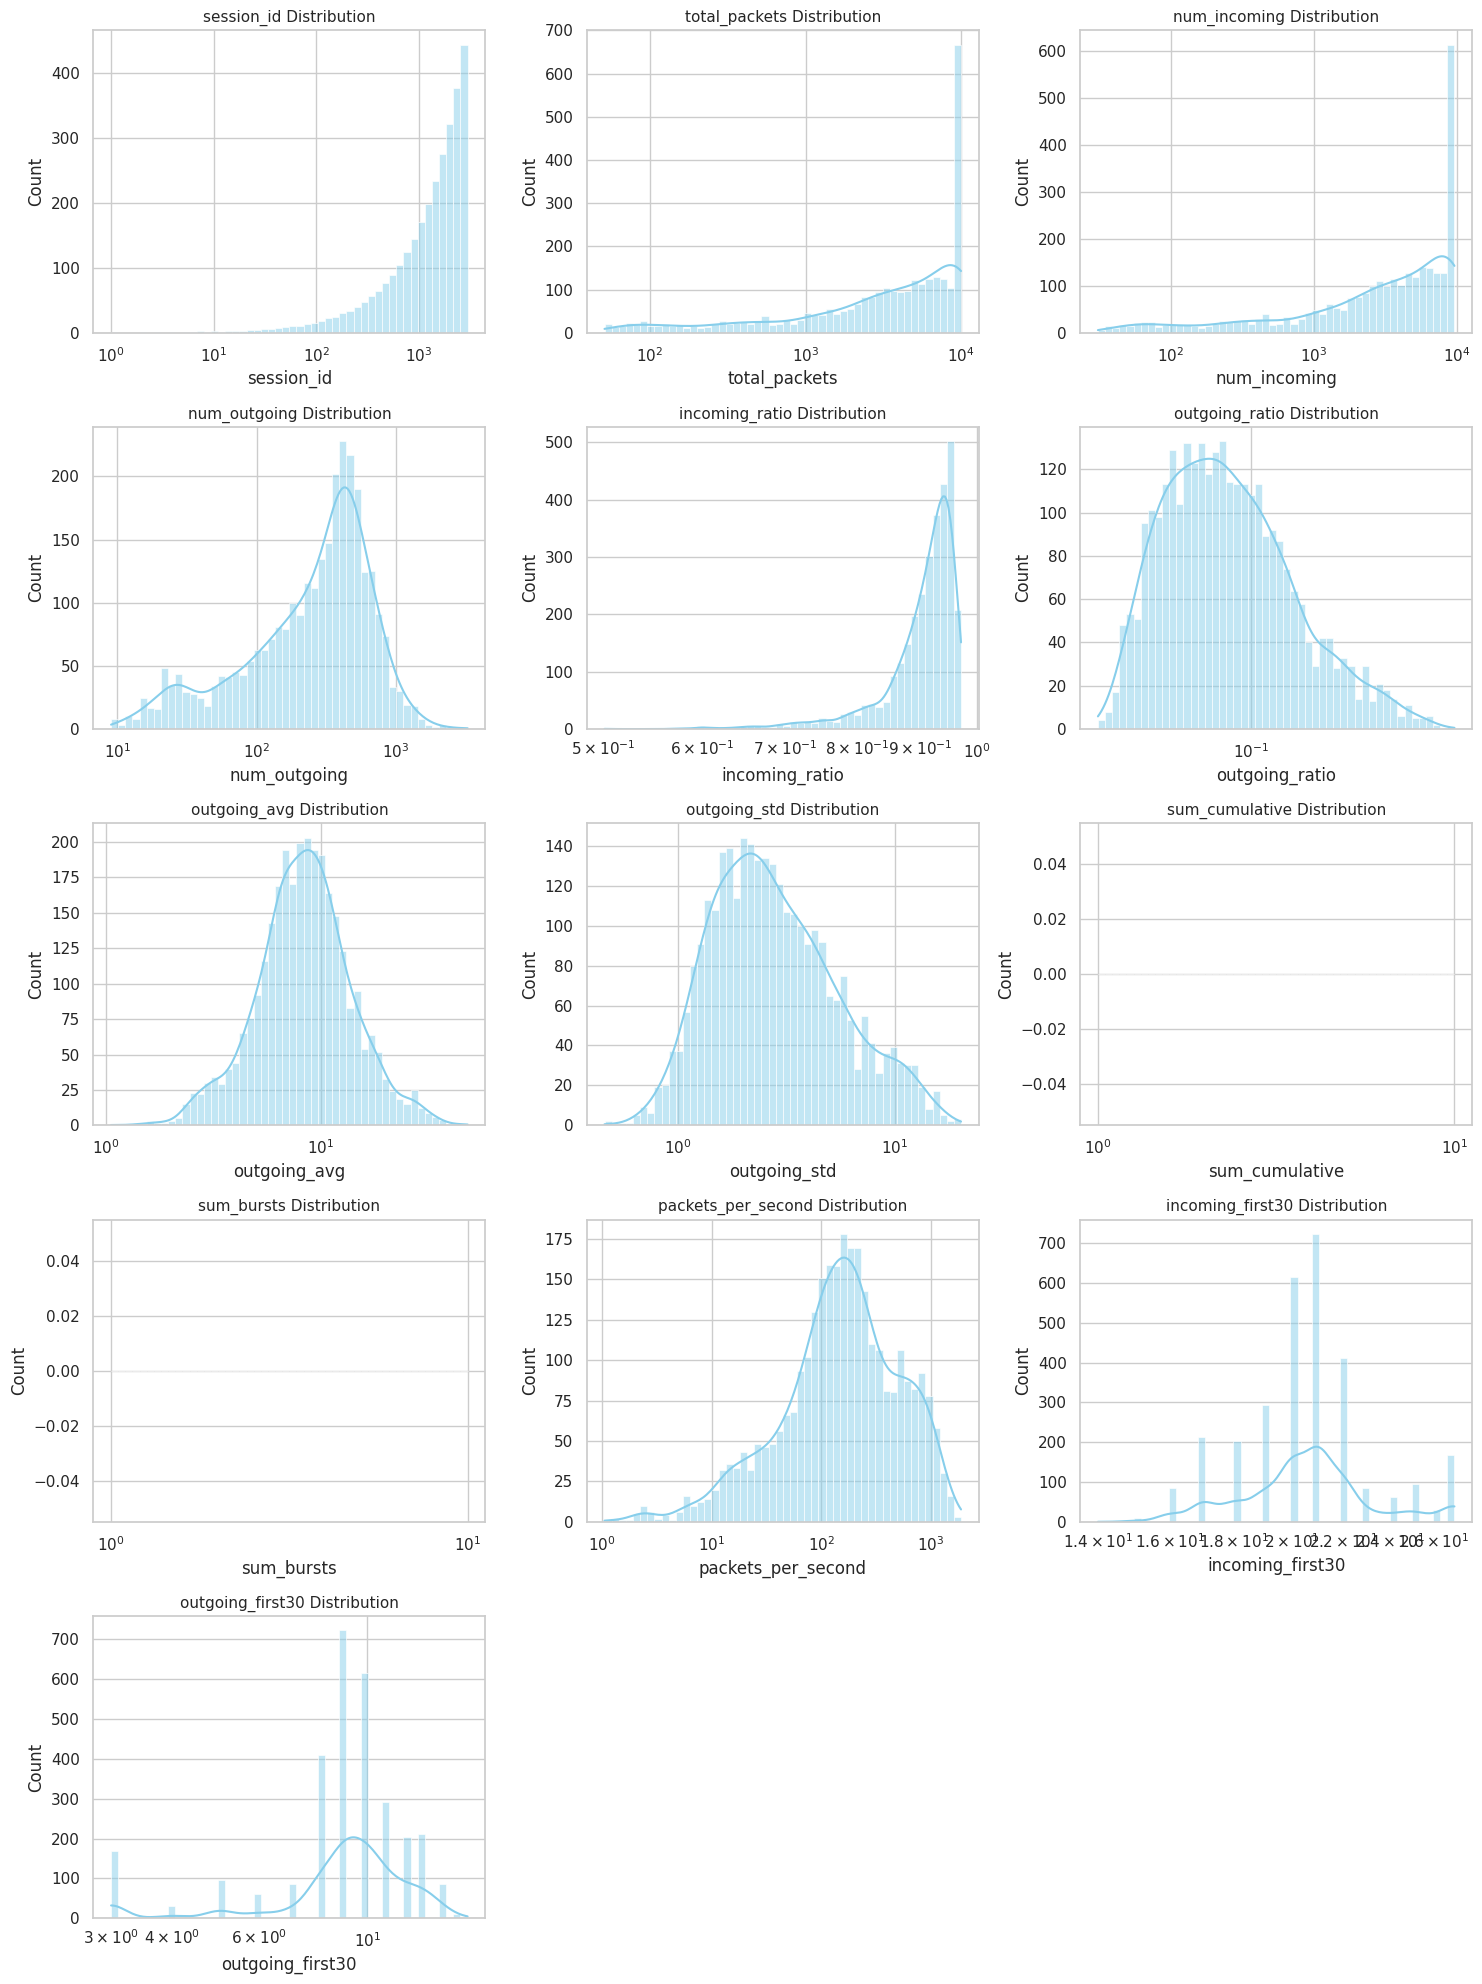

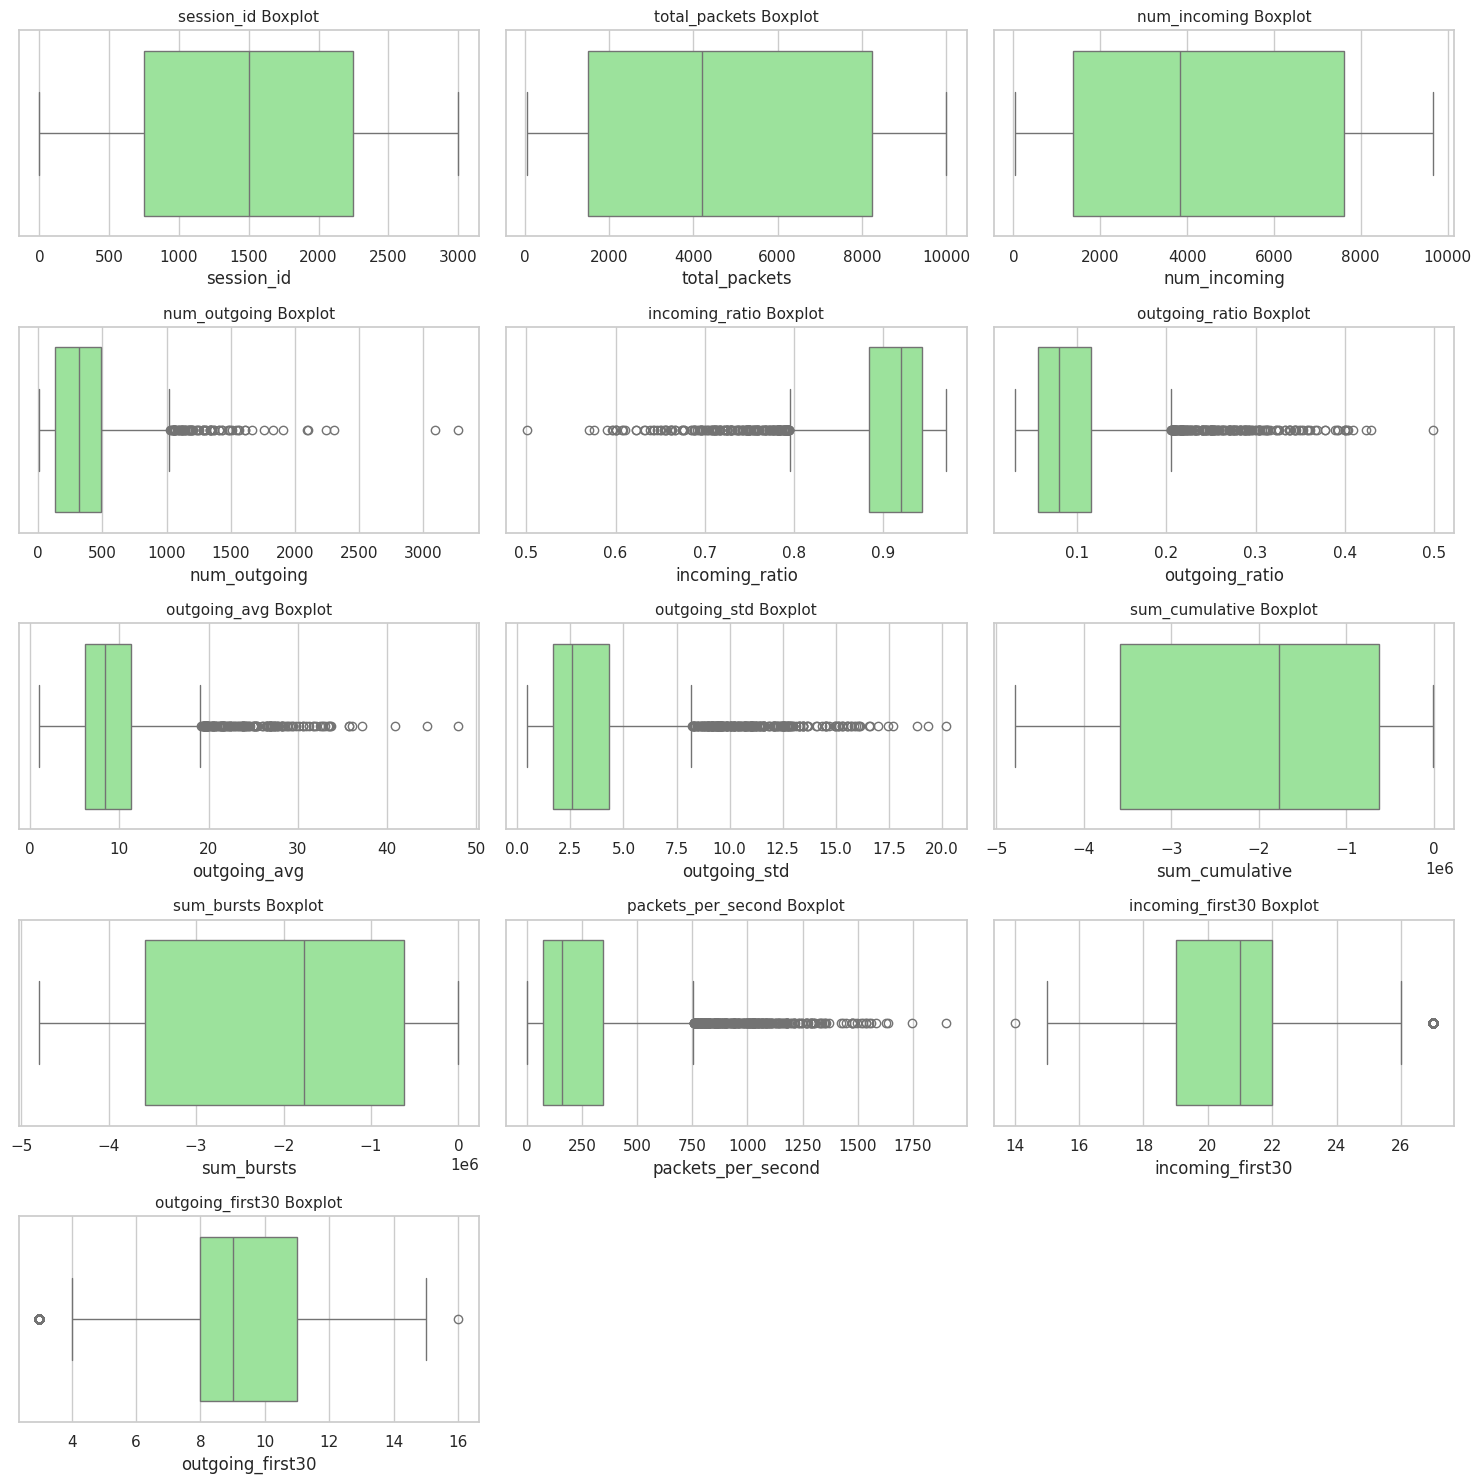

In [ ]:
# 분포 ==========================================

cont_numeric_cols = df_cat.select_dtypes(include=np.number).columns

n_cols = 3  # 한 행 3개
n_rows = int(np.ceil(len(cont_numeric_cols) / n_cols))

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(cont_numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_cat[col], kde=True, bins=50, color="skyblue", edgecolor=None, log_scale=True)
    plt.title(f"{col} Distribution", fontsize=11)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Box plot ==========================================

plt.figure(figsize=(5 * n_cols, 3 * n_rows))

for i, col in enumerate(cont_numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df_cat[col], color="lightgreen")
    plt.title(f"{col} Boxplot", fontsize=11)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

### 3-3. 시각화 및 분석 - Correlation & Separability

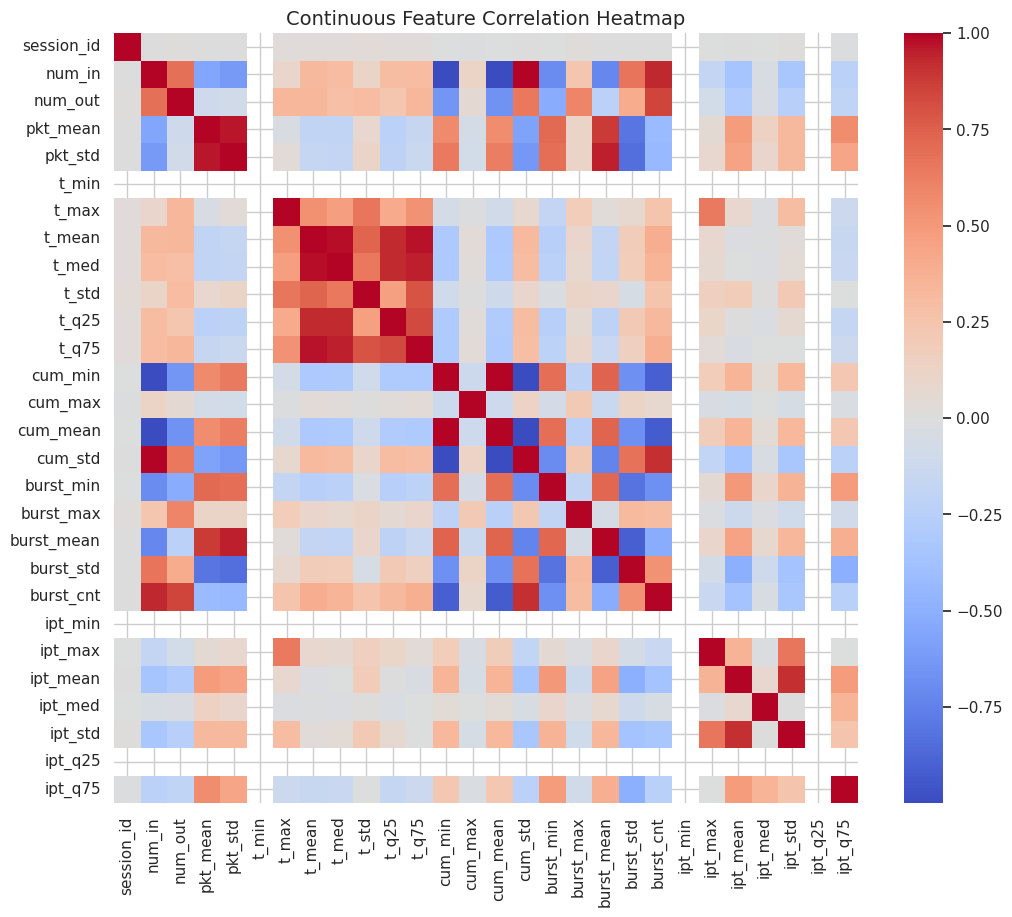

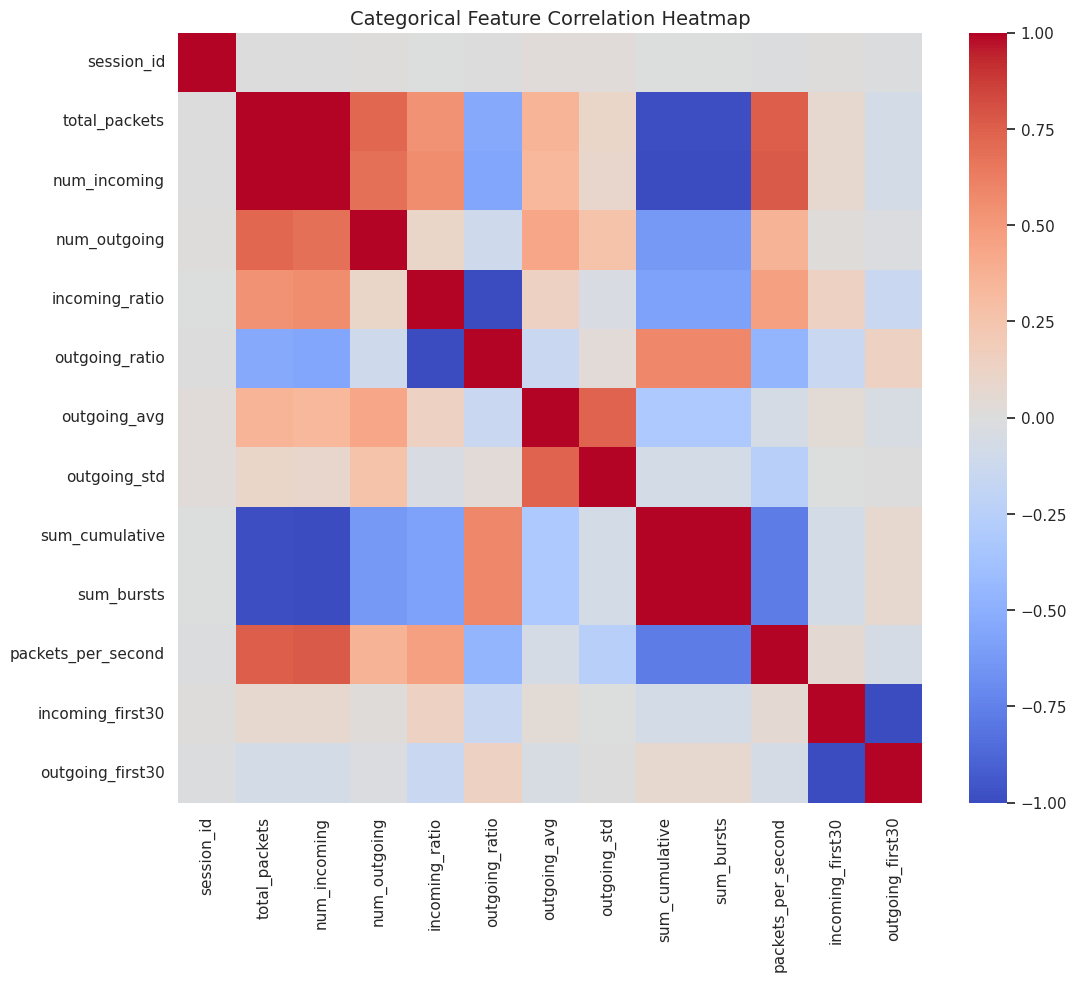

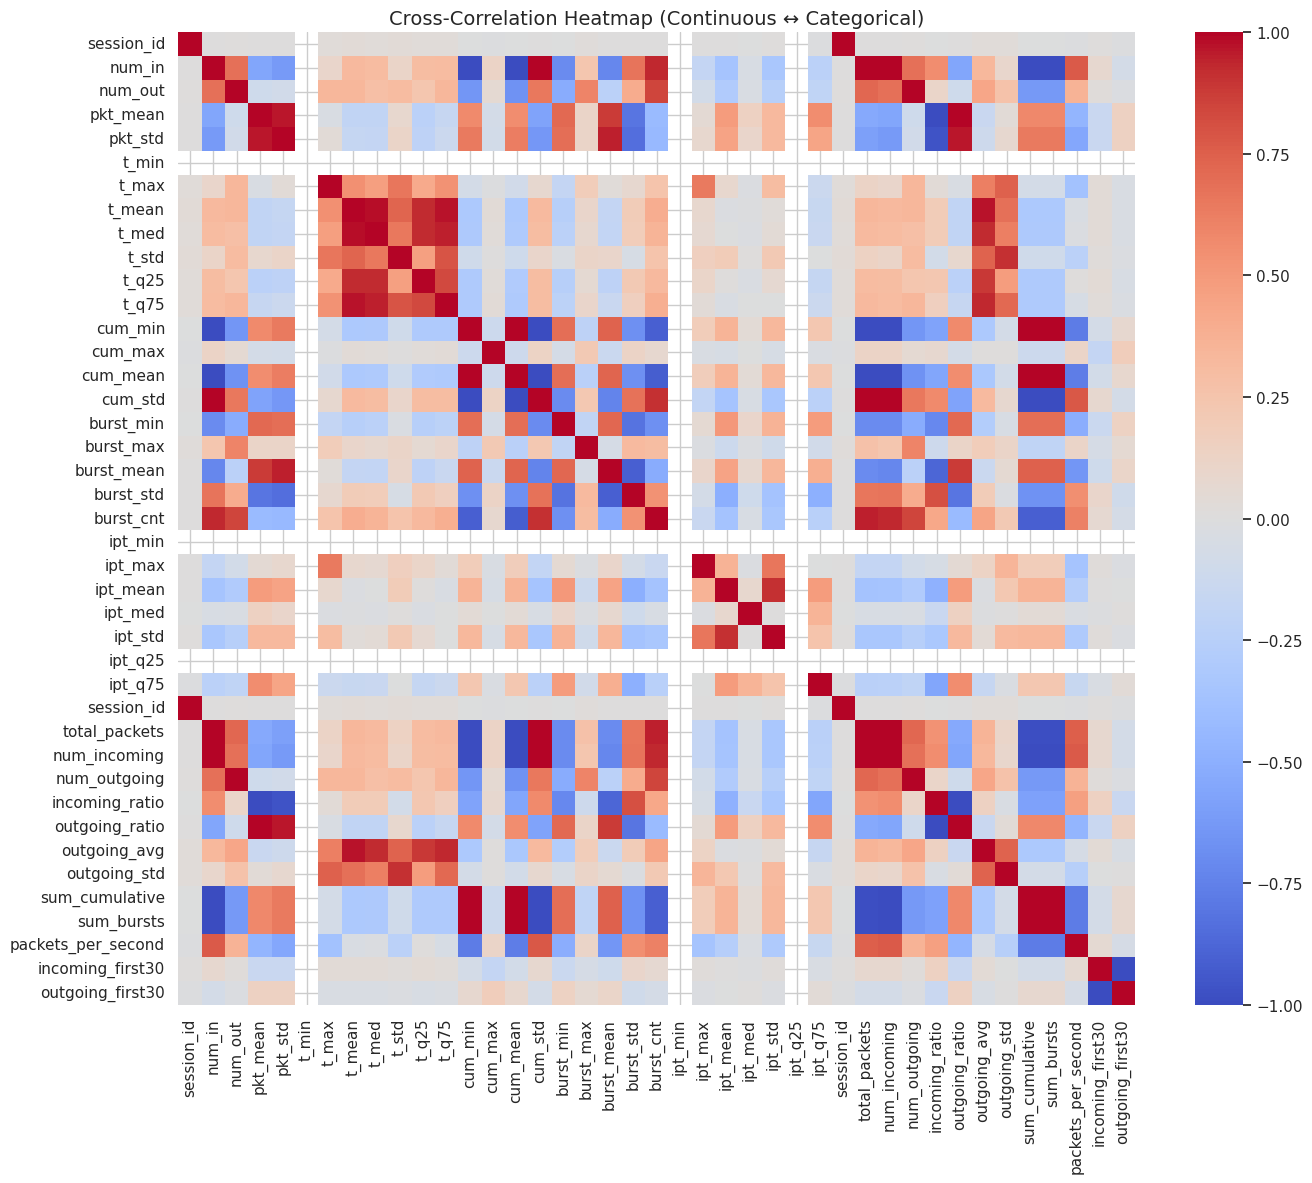

Top 10 strongest cross-correlations:

num_in          num_incoming      1.000000
num_out         num_outgoing      1.000000
sum_cumulative  sum_bursts        1.000000
session_id      session_id        1.000000
pkt_mean        outgoing_ratio    1.000000
cum_min         sum_cumulative    0.999627
                sum_bursts        0.999627
                cum_mean          0.998824
num_in          cum_std           0.998388
cum_std         num_incoming      0.998388
dtype: float64
Highly correlated features (to drop): ['pkt_std', 't_med', 't_q25', 't_q75', 'cum_min', 'cum_mean', 'cum_std', 'burst_mean', 'burst_std', 'burst_cnt', 'ipt_std']
Reduced feature count: 17


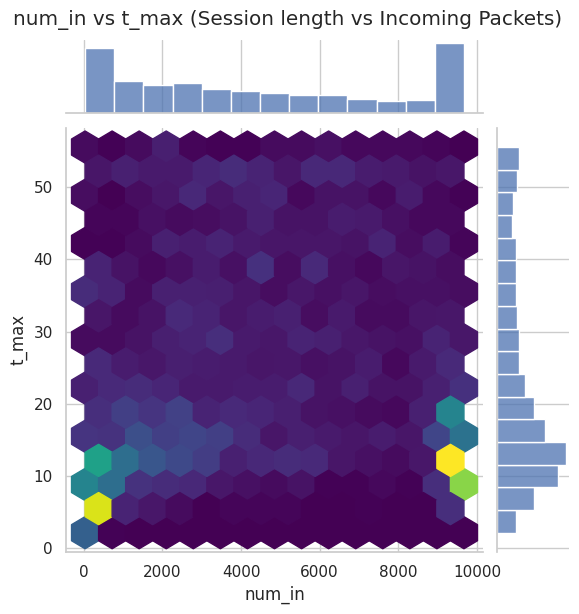

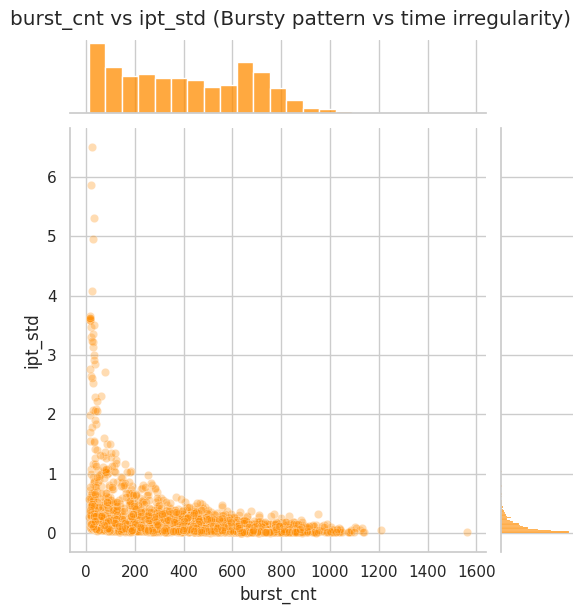

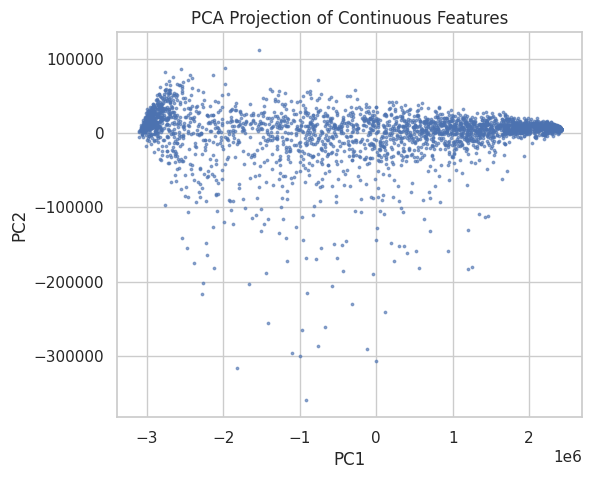

Explained variance ratio: [9.99458252e-01 3.95635951e-04]


In [ ]:
# feature 상관관계 heatmap -> 색상이 진할수록(R/B) 강한 상관관계

# 1. Continuous feature correlation
corr_cont = df_cont.corr(numeric_only=True)
plt.figure(figsize=(12,10))
sns.heatmap(corr_cont, cmap="coolwarm", center=0, cbar=True)
plt.title("Continuous Feature Correlation Heatmap", fontsize=14)
plt.show()

# 2. Categorical feature correlation
corr_cat = df_cat.corr(numeric_only=True)
plt.figure(figsize=(12,10))
sns.heatmap(corr_cat, cmap="coolwarm", center=0, cbar=True)
plt.title("Categorical Feature Correlation Heatmap", fontsize=14)
plt.show()

#  3. Cross-correlation (continuous vs categorical)
#    continuous는 df_cont, categorical은 df_cat → 공통 세션 기준으로 concat
df_cross = pd.concat([df_cont, df_cat], axis=1)
corr_cross = df_cross.corr(numeric_only=True)

# cross만 강조해서 보기 위해 continuous & categorical 구분선 추가
cont_cols = df_cont.select_dtypes(include=np.number).columns
cat_cols  = df_cat.select_dtypes(include=np.number).columns

plt.figure(figsize=(14,12))
sns.heatmap(corr_cross, cmap="coolwarm", center=0, cbar=True)
plt.title("Cross-Correlation Heatmap (Continuous ↔ Categorical)", fontsize=14)

# 가독성 개선
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# correlation 높은 feature 쌍 10개 출력
corr_pairs = (
    corr_cross.where(np.triu(np.ones(corr_cross.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)
print("Top 10 strongest cross-correlations:\n")
print(corr_pairs.head(10))

# 상관관계가 높은 변수 제거하여 feature redundancy 개선
threshold = 0.9 # 기준: 0.9 이상
corr_matrix_cont = corr_cont.abs()
upper_tri = corr_matrix_cont.where(np.triu(np.ones(corr_matrix_cont.shape), k=1).astype(bool))
to_drop_cont = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
print("Highly correlated features (to drop):", to_drop_cont)

# 축약된 feature set -> 정보 중복이 적은 주요 feature 집합만 추출 가능
df_reduced = df_cont.drop(columns=[c for c in to_drop_cont if c in df_cont.columns])
print("Reduced feature count:", df_reduced.shape[1])

# 관계가 뚜렷한 feature 쌍만 시각화
sns.jointplot(data=df_cont, x='num_in', y='t_max', kind='hex', cmap='viridis')
plt.suptitle("num_in vs t_max (Session length vs Incoming Packets)", y=1.02)
plt.show()

sns.jointplot(data=df_cont, x='burst_cnt', y='ipt_std', kind='scatter', alpha=0.3, color='darkorange')
plt.suptitle("burst_cnt vs ipt_std (Bursty pattern vs time irregularity)", y=1.02)
plt.show()

# PCA로 시각화 -> continuous feature들이 세션별로 얼마나 분리 가능한지
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_cont.select_dtypes(include=np.number))
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=3, alpha=0.6)
plt.title("PCA Projection of Continuous Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)
